In [ ]:
!pip install -U -q PyDrive

In [ ]:
import sqlite3
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
!mkdir data

In [ ]:
file_id = '1KiOvhsdjJqaUCLJa5adZXEtQ_72s8Eb6'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('data/checking-logs.sqlite')

In [ ]:
conn = sqlite3.connect('data/checking-logs.sqlite')

In [ ]:
commits = pd.io.sql.read_sql(
    "select timestamp from checker where uid like 'user_%'",
    conn, parse_dates=['timestamp']
    )

In [ ]:
commits.head()

,timestamp
0,2020-04-17 05:19:02.744528
1,2020-04-17 05:22:35.249331
2,2020-04-17 05:22:45.549397
3,2020-04-17 05:34:14.691200
4,2020-04-17 05:34:24.422370


In [ ]:
commits['date'] = commits['timestamp'].dt.floor('d')
commits['time'] = pd.to_datetime(commits['timestamp'].dt.time.astype(str),
                                 format='%H:%M:%S.%f')
commits = commits.drop('timestamp', axis=1)

In [ ]:
commits.head()

,date,time
0,2020-04-17,1900-01-01 05:19:02.744528
1,2020-04-17,1900-01-01 05:22:35.249331
2,2020-04-17,1900-01-01 05:22:45.549397
3,2020-04-17,1900-01-01 05:34:14.691200
4,2020-04-17,1900-01-01 05:34:24.422370


In [ ]:
commits['daytime'] = pd.cut(
    commits.time, [pd.to_datetime(
        h, unit='h', origin=pd.Timestamp('1900-01-01')
        ) for h in [0, 4, 10, 17, 24]], right=False,
    labels=['night', 'morning', 'afternoon', 'evening'], include_lowest=True)

In [ ]:
commits.head()

,date,time,daytime
0,2020-04-17,1900-01-01 05:19:02.744528,morning
1,2020-04-17,1900-01-01 05:22:35.249331,morning
2,2020-04-17,1900-01-01 05:22:45.549397,morning
3,2020-04-17,1900-01-01 05:34:14.691200,morning
4,2020-04-17,1900-01-01 05:34:24.422370,morning


In [ ]:
commits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3207 entries, 0 to 3206
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     3207 non-null   datetime64[ns]
 1   time     3207 non-null   datetime64[ns]
 2   daytime  3207 non-null   category      
dtypes: category(1), datetime64[ns](2)
memory usage: 53.6 KB


In [ ]:
df = commits.groupby('daytime').date.value_counts().unstack(0)

In [ ]:
df.head()

daytime,night,morning,afternoon,evening
date,,,,
2020-04-17,NaN,13.0,10.0,NaN
2020-04-18,NaN,1.0,33.0,35.0
2020-04-19,2.0,4.0,16.0,11.0
2020-04-20,NaN,NaN,12.0,13.0
2020-04-21,NaN,NaN,NaN,25.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35 entries, 2020-04-17 to 2020-05-21
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   night      7 non-null      float64
 1   morning    23 non-null     float64
 2   afternoon  30 non-null     float64
 3   evening    30 non-null     float64
dtypes: float64(4)
memory usage: 1.4 KB


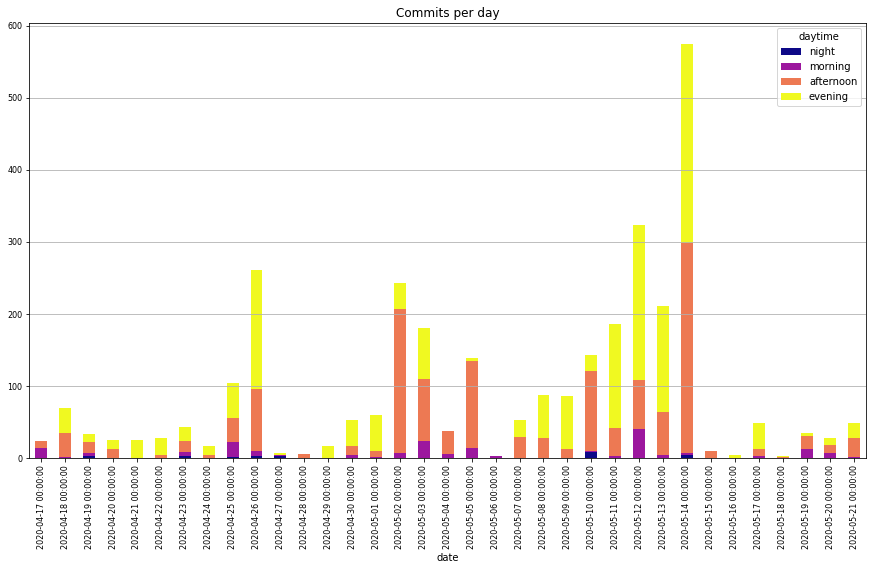

In [ ]:
ax = df.plot.bar(stacked=True, figsize=(15, 8), title='Commits per day',
                 rot=90, fontsize=8, colormap='plasma')
ax.grid(axis='y')

In [ ]:
df.sum()

daytime
night          21.0
morning       184.0
afternoon    1391.0
evening      1611.0
dtype: float64

Самые частые значения daytime: afternoon, evening.

In [ ]:
df.loc[df['evening'] > df['afternoon']].sum(axis=1).idxmax()

Timestamp('2020-05-12 00:00:00')

Больше всего коммитов среди дней, в которые количество коммитов вечером было больше, чем днём, было 2020-05-12.

In [ ]:
conn.close()